In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import lmfit
from scipy import interpolate
from scipy import stats
import h5py
import pandas
import tables

In [2]:
f1='/Users/philipharris/Dropbox/Physics/8S50_2022/test2/codec/events_anomalydetection_v2.features.h5'
f2='/Users/philipharris/Dropbox/Physics/8S50_2022/test2/codec/events_anomalydetection_Z_XY_qqq.features.h5'
f_qcd = h5py.File(f2,'r')

df1 = pandas.read_hdf(f1)
df2 = pandas.read_hdf(f2)

1100000
100000


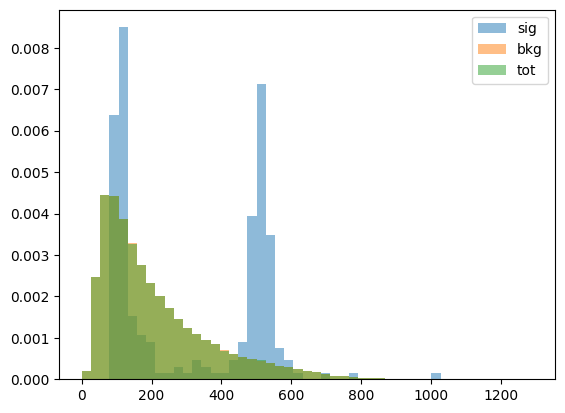

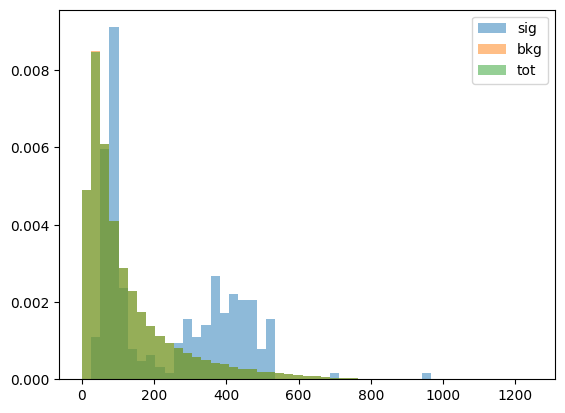

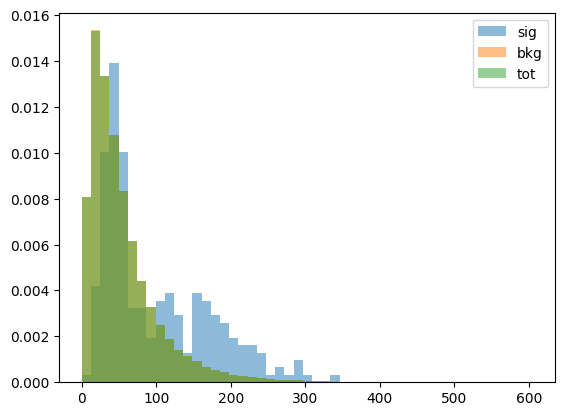

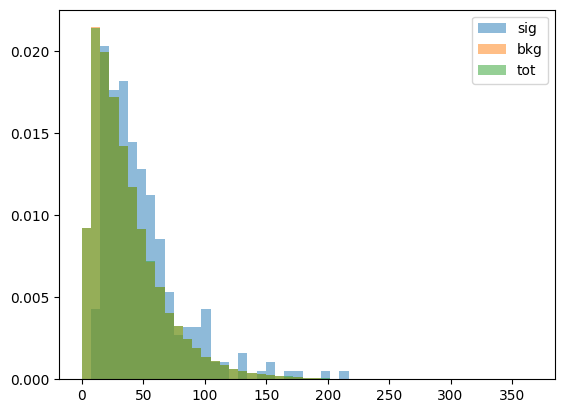

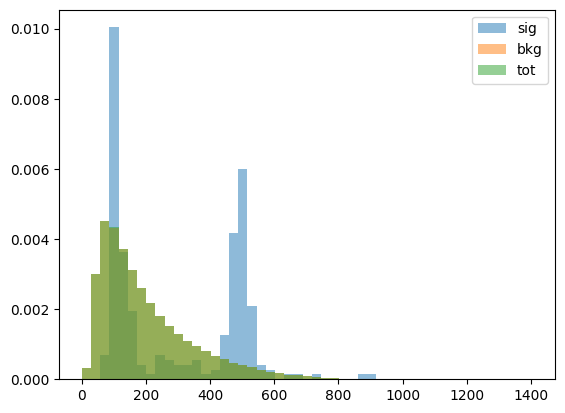

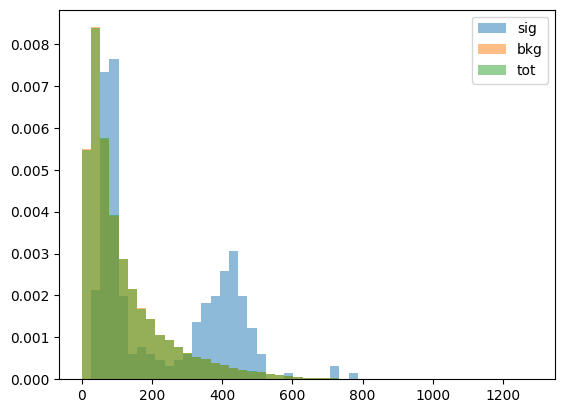

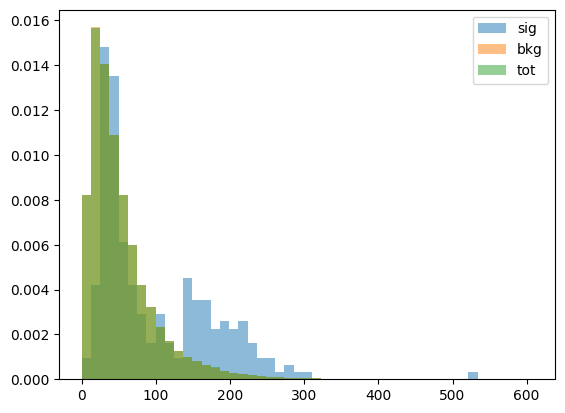

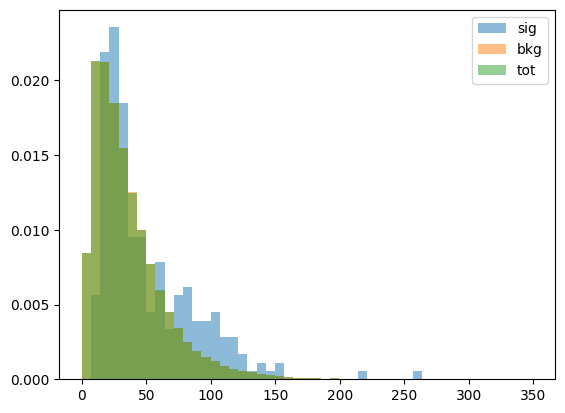

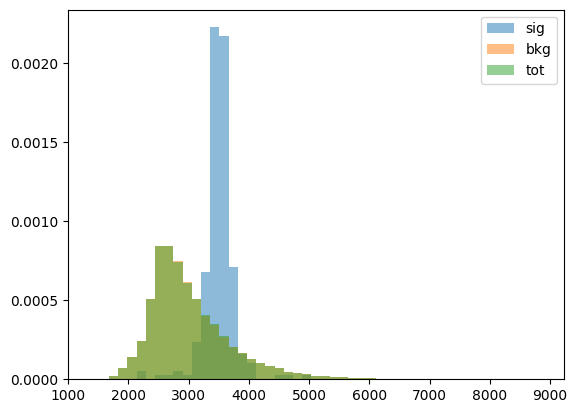

1100000
100000


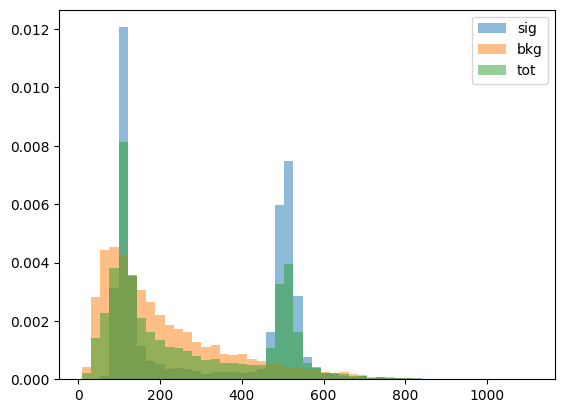

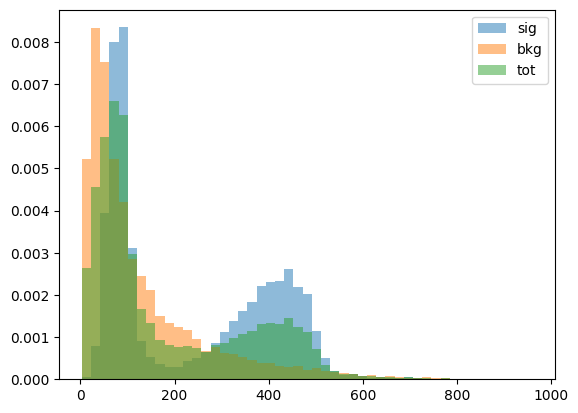

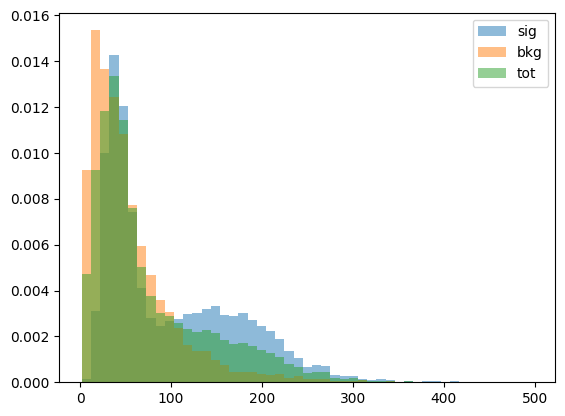

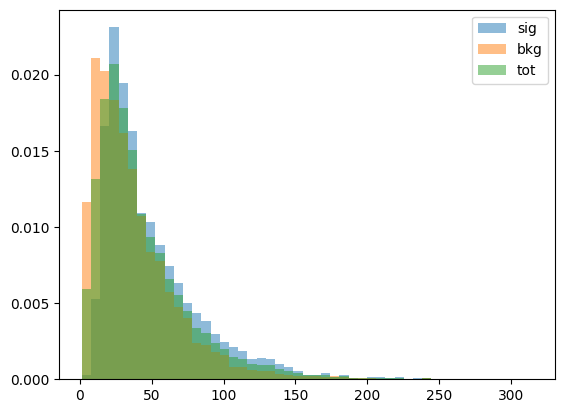

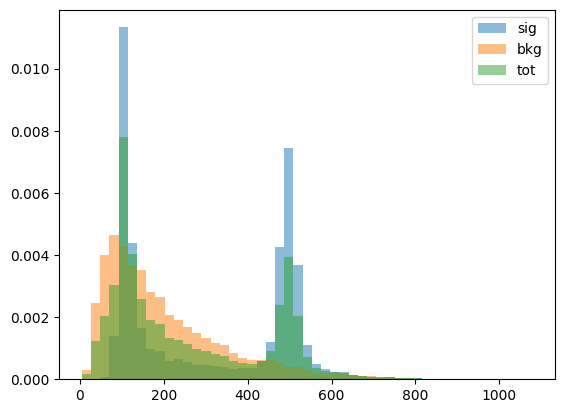

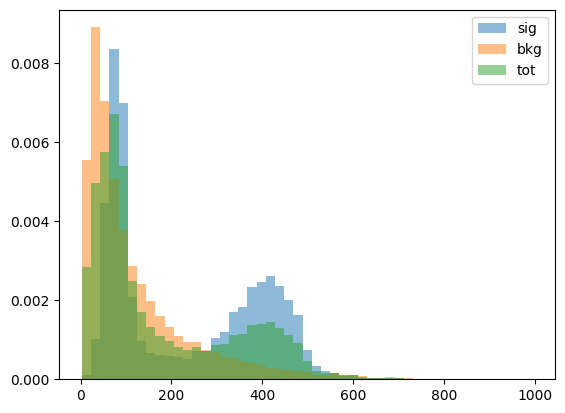

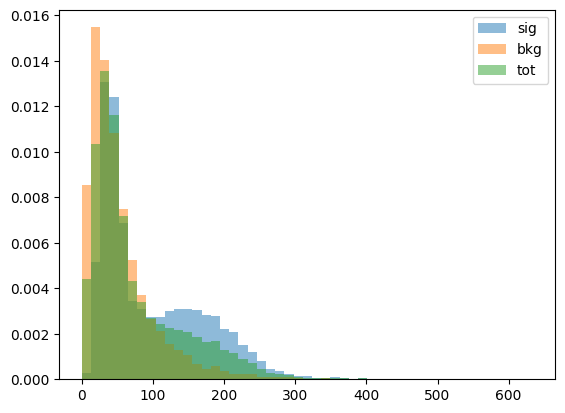

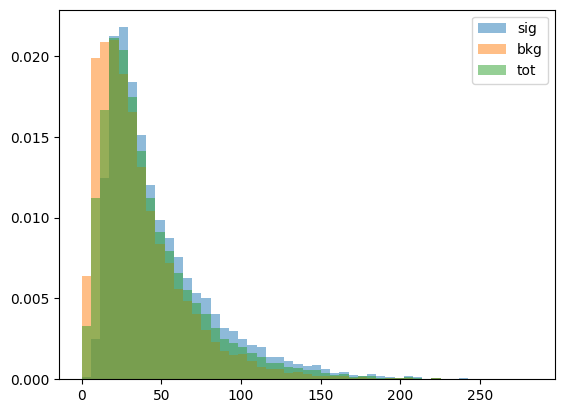

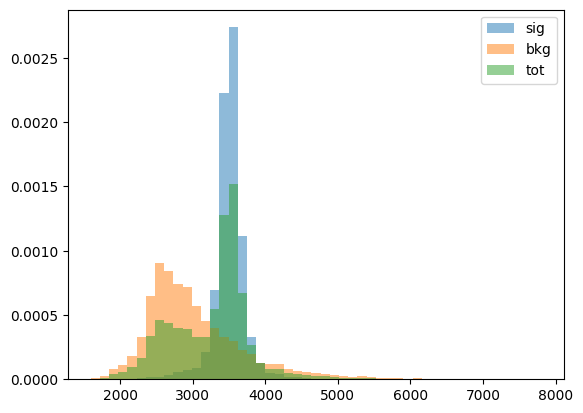

In [103]:
class DataSet(Dataset):
    def __init__(self, samples, labels, disc):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        self.disc    = disc
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        z = self.disc[index]
        return x, y, z 
    
def mass(iDS): 
    e12   = np.sqrt(iDS.pxj1**2 + iDS.pyj1**2 + iDS.pzj1**2 + iDS.mj1**2)
    e22   = np.sqrt(iDS.pxj2**2 + iDS.pyj2**2 + iDS.pzj2**2 + iDS.mj2**2)
    etot  = e12 + e22
    pxtot = iDS.pxj1 + iDS.pxj2
    pytot = iDS.pyj1 + iDS.pyj2
    pztot = iDS.pzj1 + iDS.pzj2
    return np.sqrt(etot**2 - pxtot**2 - pytot**2 - pztot**2)

def makeNP(iDS):
    massvals=mass(iDS)
    tmp=iDS[["mj1","tau1j1","tau2j1","tau3j1","mj2","tau1j2","tau2j2","tau3j2"]].to_numpy()
    massvals=np.reshape(massvals,(len(massvals),1))
    tmp=np.hstack((tmp,massvals))
    print(len(tmp))
    return tmp

def makeDataSet(iD,iNS,iNB):
    pD    = torch.from_numpy(iD)
    discs = torch.cat((torch.ones(iNS), torch.zeros(iNB)))
    rand  = torch.randperm(len(pD))
    pXD   = pD[rand]
    tot   = pXD[:,:-1].float()   #this is our discriminator we want to learn
    label = pXD[:,-1].float()  ####Note this is a regression, so we want to put y=f(x)
    xdisc = discs[rand]
    datatrain=DataSet(samples=tot,labels=label, disc=xdisc)
    bkgdatatrain=DataSet(samples=pD[iNS:,:-1].float(),labels=pD[iNS:,-1].float(),disc=torch.zeros(iNB))
    return datatrain,bkgdatatrain,pD[0:iNS].float(),pD[iNS:].float()

def plotSigBkg(iN,sig,bkg,nbins=50):
    tot=torch.cat((sig,bkg))
    for pVar in range(iN+2):
        xmin=torch.min(bkg[:,pVar])
        xmax=torch.max(bkg[:,pVar])
        binrange=np.arange(xmin,xmax,(xmax-xmin)/nbins)
        plt.hist(sig[:,pVar],bins=binrange,density=True,alpha=0.5,label='sig')
        plt.hist(bkg[:,pVar],bins=binrange,density=True,alpha=0.5,label='bkg')
        plt.hist(tot[:,pVar],bins=binrange,density=True,alpha=0.5,label='tot')
        plt.legend()
        plt.show()

def setupData(iD1,iD2,iNB,iNS,iStart=0,iSStart=0):
    nparr1=makeNP(iD1)
    nparr2=makeNP(iD2)
    nparr1=nparr1[iStart:(iStart+iNB)]
    nparr2=nparr2[iSStart:(iSStart+iNS)]
    pdata = np.vstack((nparr2,nparr1))
    data,bkgdata,test_sig,test_bkg=makeDataSet(pdata,len(nparr2),len(nparr1))
    plotSigBkg(7,test_sig,test_bkg)
    return data,bkgdata,test_sig,test_bkg

#massvec1 = mass(df1)
#massvec2 = mass(df2)
#bins=np.arange(2000,8000,20)
#plt.hist(massvec1,bins=bins,alpha=0.5)
#plt.hist(massvec2,bins=bins,alpha=0.5)
#plt.show()
dataset,mcdataset,sig,bkg=setupData(df1,df2,89750,250)
dataset2,mcdataset2,sig2,bkg2=setupData(df1,df2,9000,9000,90500,1000)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 169
    # data points      = 40
    # variables        = 3
    chi-square         = 66.3542115
    reduced chi-square = 1.79335707
    Akaike info crit   = 26.2451112
    Bayesian info crit = 31.3117495
    R-squared          = 0.99613079
[[Variables]]
    par0:  0.11112401 +/- 0.07966985 (71.69%) (init = 0.3)
    par1: -17.1538366 +/- 0.93392129 (5.44%) (init = -20)
    par2: -0.78232447 +/- 0.31983027 (40.88%) (init = -2.5)
    par3:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(par0, par2) = -0.999
    C(par0, par1) = -0.997
    C(par1, par2) = 0.993
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 285
    # data points      = 40
    # variables        = 4
    chi-square         = 49.5511770
    reduced chi-square = 1.37642158
    Akaike info crit   = 16.5650624
    Bayesian info crit = 23.3205802
    R-squared          = 0.99711060
[[Variables]]
    par

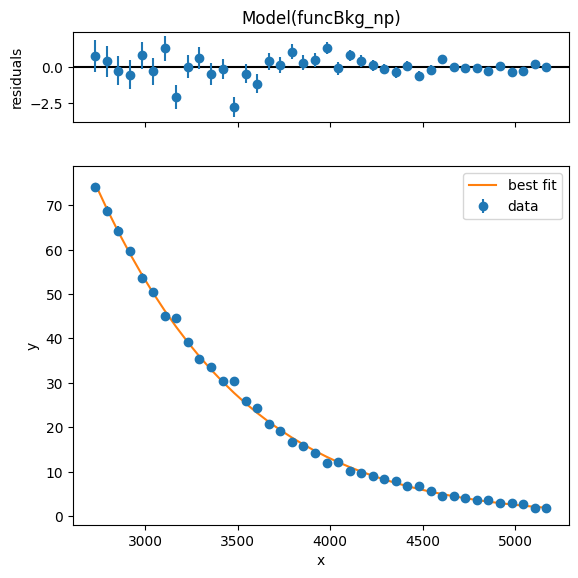

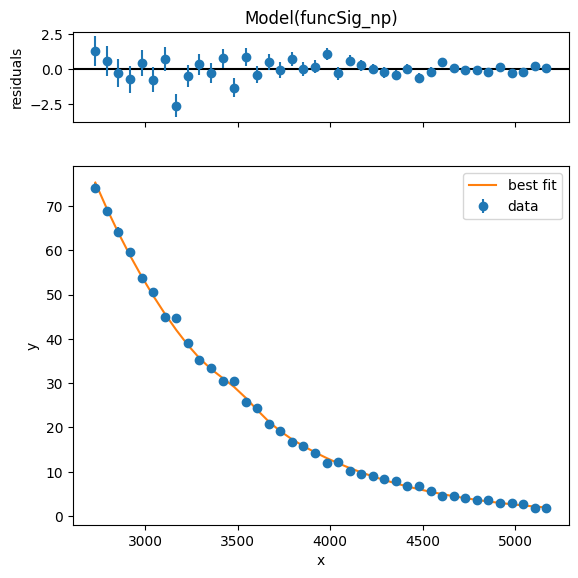

In [104]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from splitfitter import fitGausDijet

nbins=40
xmax=5200.0
xmin=2700.0
delta      = (xmax - xmin) / nbins
BIN_Table  = torch.arange(start=0, end=nbins+1, step=1) * delta +xmin
h_r        = 0.5*(BIN_Table[1:] + BIN_Table[:-1])
input=torch.cat((sig[:,-1],bkg[:,-1]))
tmp=fitGausDijet()
yhist,xbins=torch.histogram(input,BIN_Table,density=False)
yerr=((torch.sqrt(yhist))/delta).detach().numpy()
ytmp=(yhist*1./delta).detach().numpy()
xtmp=h_r.detach().numpy()
#plt.plot(xtmp,yhist)
#plt.show()
_,result,_=tmp.fitBkg(xtmp,ytmp,yerr)
result.plot()
lmfit.report_fit(result)

_,result,_=tmp.fitSig(xtmp,ytmp,yerr)
result.plot()
lmfit.report_fit(result)

In [105]:
%load_ext autoreload
%autoreload 2
from splitfitter import simple_MLPFit_lmfit,fitGausLin,fitGausPowLaw,fitGausFlat,fitGausDijet,plotPerf,plotCheck
rw_model = simple_MLPFit_lmfit(dataset,8,k_fold=2,nhidden=128,out_channels=1,act_out=False,n_epochs=101,fit_opt=2,bkg_loss=1.5,iFitPFunc=fitGausDijet(),iFitFFunc=fitGausDijet(),
                                massDeco=0.,mc_data=mcdataset,bkgPressure=True,lambScale=0.0,batch_size=45000,lambvar=0.)

#rw_model.pretrain(dataset2,18000,50)
rw_model.train(31)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
K-fold 0
Epoch: 0 LOSS train: 8.491742134094238 Pars 1: -0.216147007297824 - 2: 5.675983768346491 deco: 0
Epoch: 10 LOSS train: 8.256183624267578 Pars 1: 0 - 2: 5.404143373321318 deco: 0
Epoch: 20 LOSS train: 8.256074905395508 Pars 1: 0 - 2: 5.404052651500379 deco: 0
Epoch: 30 LOSS train: 8.256067276000977 Pars 1: 0 - 2: 5.404042782482094 deco: 0
K-fold 1
Overtrained loss -7.903123378753662 valid 165.42611694335938


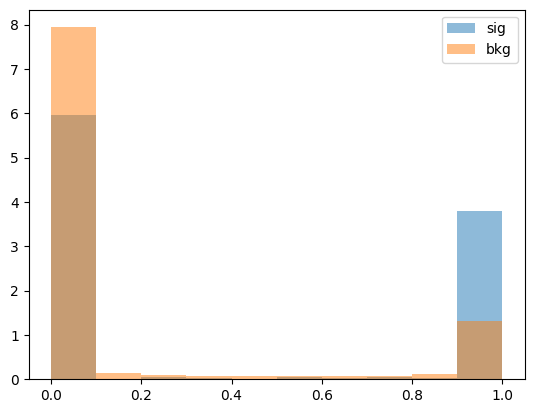

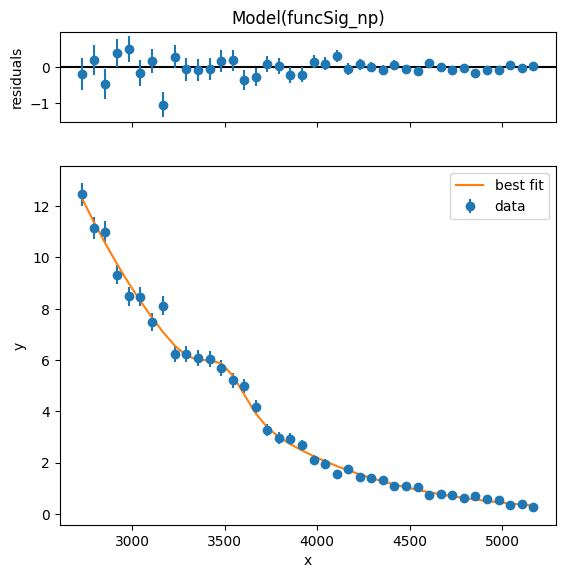

Pass Significance: 34.481499513536335
Fail Significance: 10.339438489058196


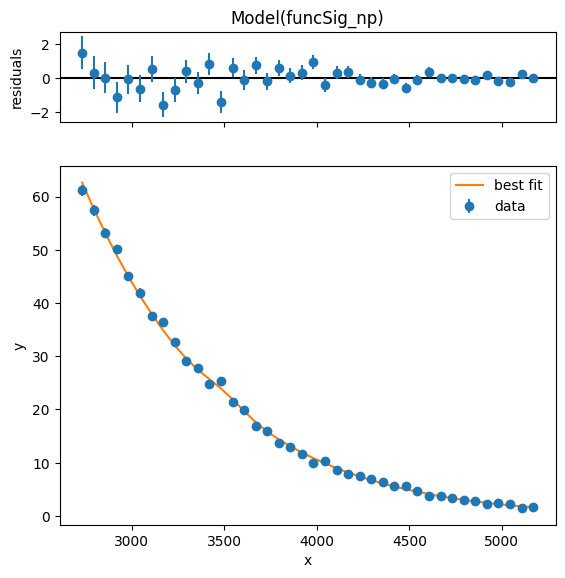

here!
torch.Size([89500, 1]) torch.Size([89500])
tensor([3307.2195, 3107.6206, 3004.8953,  ..., 3287.8750, 3002.4390,
        2970.4158])
Bkg Significance: 10.968322879219002


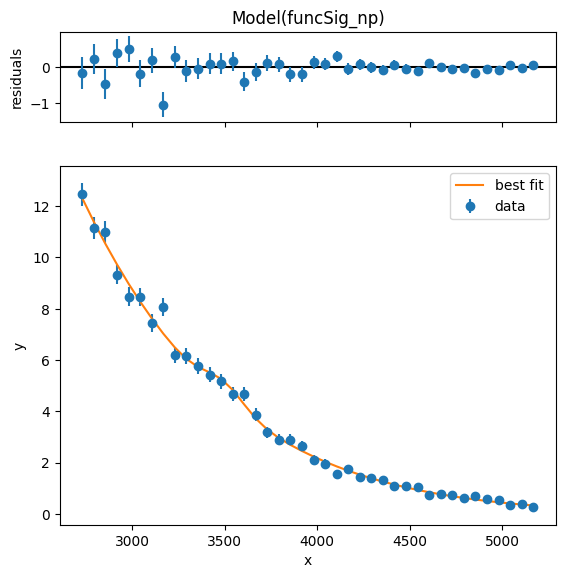

In [102]:
plotPerf(sig,bkg,rw_model)

In [96]:
rw_model.train(21)

K-fold 0
Epoch: 0 LOSS train: nan Pars 1: 0 - 2: 0 deco: 0
Epoch: 10 LOSS train: nan Pars 1: 0 - 2: 0 deco: 0
Epoch: 20 LOSS train: nan Pars 1: 0 - 2: 0 deco: 0
K-fold 1
Epoch: 0 LOSS train: nan Pars 1: 0 - 2: 0 deco: 0
Epoch: 10 LOSS train: nan Pars 1: 0 - 2: 0 deco: 0
Epoch: 20 LOSS train: nan Pars 1: 0 - 2: 0 deco: 0


Significance: 58.73413337542815


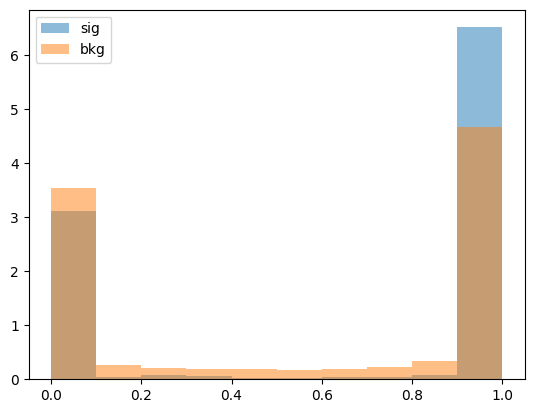

Over train Significance: 85.86118709082028


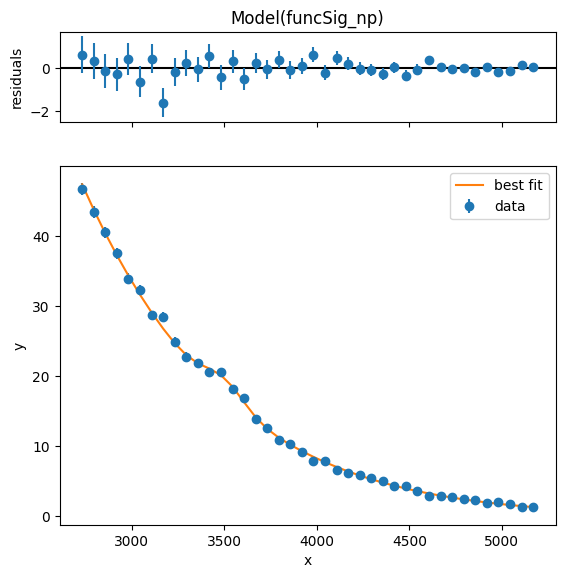

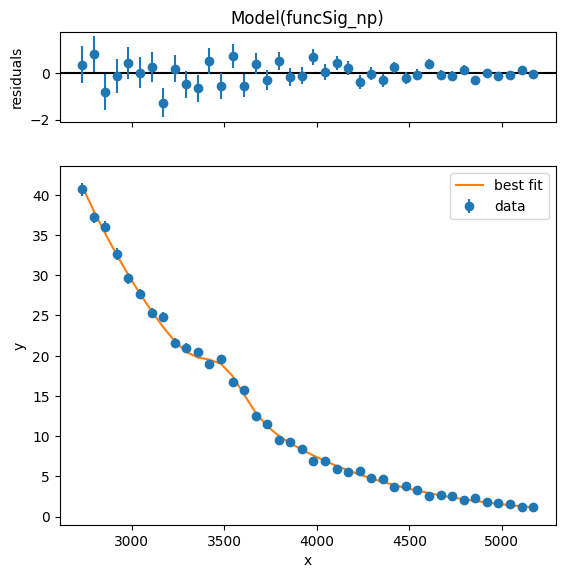

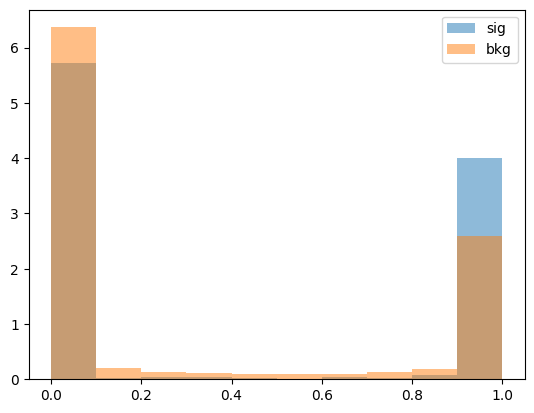

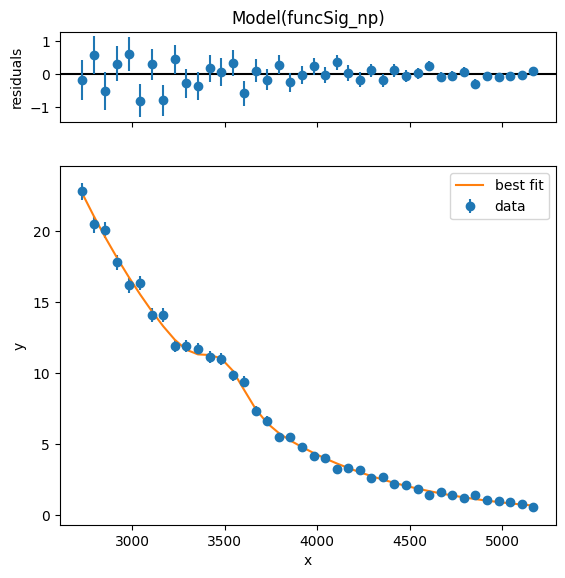

Pass Significance: 59.27618473468458
Fail Significance: 20.622814247756978


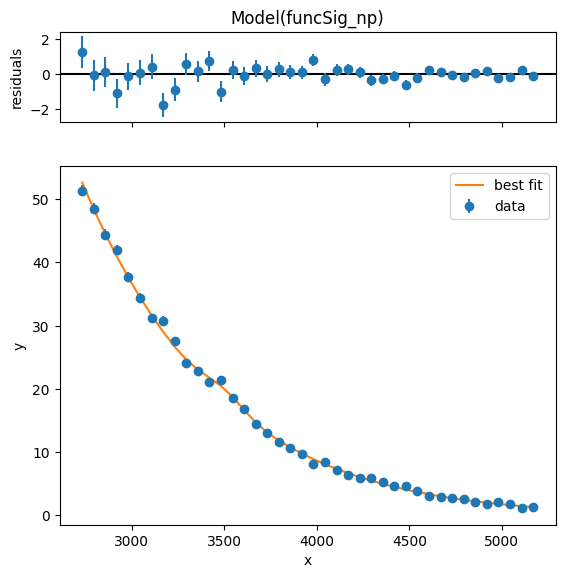

here!
torch.Size([90000, 1]) torch.Size([90000])
tensor([3307.2195, 3107.6206, 3004.8953,  ..., 3489.8962, 3075.4778,
        3797.5076])
Bkg Significance: 12.128572860859293


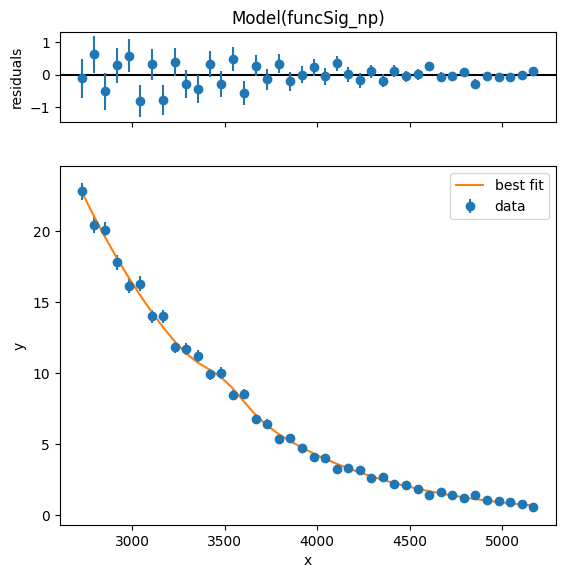

In [86]:
plotCheck(rw_model)
plotPerf(sig,bkg,rw_model)